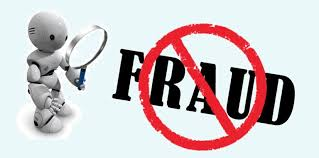

In [52]:
from IPython.display import Image
Image("images.jpeg")

<b>Data Description</b>:

The dataset contains two-days credit card transactions made in September 2013 by European cardholders. 
The dataset is highly unbalanced with a low percentage of fraudulent transactions within several records of normal transactions. 

The negative class(No Frauds) accounts for 99.83% of the dataset.
The positive class (frauds) account for 0.172% (492 frauds out of 284,807 transactions) of all transactions.

Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. 
Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. 
Feature 'Class' is the target variable with value 1 in case of fraud and 0 otherwise.

In [135]:
#import libraries
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import time
import lightgbm as lgb
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import matplotlib.patches as mpatches
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt # Plot the graphes
%matplotlib inline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import preprocessing
import seaborn as sns
from sklearn.preprocessing import StandardScaler as ss
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
sns.set()
from sklearn.model_selection import RepeatedStratifiedKFold
import sklearn.metrics as metrics
import xgboost as xgb
from sklearn.preprocessing import StandardScaler 
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_predict

In [21]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN 

In [5]:
fraud_data=pd.read_csv("creditcard.csv")
print('The dataset contains {0} rows and {1} columns. '.format(fraud_data.shape[0],fraud_data.shape[1]))

The dataset contains 284807 rows and 31 columns. 


In [47]:
fraud_data.Class.value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

In [22]:
scaler = StandardScaler()
fraud_data['normalize_amount']=scaler.fit_transform(fraud_data['Amount'].values.reshape(-1,1))
fraud_data['scaled_time'] = scaler.fit_transform(fraud_data['Time'].values.reshape(-1,1))

In [23]:
data=fraud_data.drop(['Amount','Time'],axis=1)

In [8]:
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,normalize_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964,-1.996583
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475,-1.996583
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686,-1.996562
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534,-1.996562
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403,-1.996541


As we can notice, most of the features are not correlated with each other. This corroborates the fact that a PCA was previously performed on the data.

<b>Lets get ready for ovresampling or go to the end of docuemnt for undersampling process</b>

In [125]:
#features and label class
X_data=data.drop(['Class'],axis=1)
y_label=data['Class']

<b>Splitting Data</b>

Before proceeding with the Random UnderSampling technique we have to separate the orginal dataframe. 
Why? for testing purposes, remember although we are splitting the data when implementing Random UnderSampling or OverSampling techniques, we want to test our models on the original testing set not on the testing set created by either of these techniques.
The main goal is to fit the model either with the dataframes that were undersample and oversample (in order for our models to detect the patterns), and test it on the original testing set.

In [126]:
#split data into training set(%80) and test set(%20)

X_train,X_test,y_train,y_test=train_test_split(X_data,y_label,stratify=y_label,test_size=.3,random_state=500)
print("training data is",X_train.shape)
print("test data is", y_train.shape)

training data is (199364, 30)
test data is (199364,)


In [38]:
# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(y_train, return_counts=True)
test_unique_label, test_counts_label = np.unique(y_test, return_counts=True)

print('Label Distributions: \n')
print(train_counts_label/ len(y_train))
print(test_counts_label/ len(y_test))

Label Distributions: 

[0.99827451 0.00172549]
[0.99826785 0.00173215]


<b>Data Sampling</b>:

As noted earlier, the dataset is unbalanced. Training unbalanced dataset with learning algorithms may lead to misclassification of minority class.
Therefore, to compensate for the unbalancedness, we will use ADASYN and SMOTE oversampling method as implemented in imbalanced-learn package to resample the dataset.

<b>ADASYN</b>

ADASYN (ADAptive SYNthetic) is an oversampling technique that adaptively generates minority data samples according to their distributions using K nearest neighbor.

<b>SMOTE</b>

The SMOTE algorithm is parameterized with k_neighbors (the number of nearest neighbors it will consider) and the number of new points you wish to create. 
Each step of the algorithm will:

Randomly select a minority point.
Randomly select any of its k_neighbors nearest neighbors belonging to the same class.
Randomly specify a lambda value in the range [0, 1].
Generate and place a new point on the vector between the two points, located lambda percent of the way from the original point.

<b>Random Under Sampling</b>

Next we will implement *"Random Under Sampling"* which basically consists of removing data in order to have a more balanced dataset and thus avoiding our models to overfitting.

Steps:
The first thing we have to do is determine how imbalanced is our class (use "value_counts()" on the class column to determine the amount for each label)

Once we determine how many instances are considered fraud transactions (Fraud = "1") , we should bring the non-fraud transactions to the same amount as fraud transactions (assuming we want a 50/50 ratio), this will be equivalent to 492 cases of fraud and 492 cases of non-fraud transactions.

After implementing this technique, we have a sub-sample of our dataframe with a 50/50 ratio with regards to our classes. Then the next step we will implement is to shuffle the data to see if our models can maintain a certain accuracy everytime we run this script.

<b>OVERSAMPLE</b>

In [39]:
#apply ADASYN oversampling
#ada=ADASYN(random_state=42)
print('original dataset shape {}'.format(Counter(y_train)))

X_res,y_res= SMOTE().fit_sample(X_train,y_train)
#X_res,y_res=ada.fit_sample(X_train,y_train)
print('Resampled dataset shape {}'.format(Counter(y_res)))

original dataset shape Counter({0: 199020, 1: 344})
Resampled dataset shape Counter({0: 199020, 1: 199020})


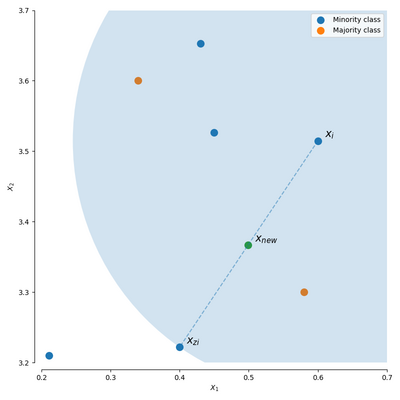

In [5]:
Image("smote.png")

Inc case of categorical variables we should apply SMOTE after the OneHotEncoding step
Synthetic Minority Over-sampling Technique for Nominal and Continuous (SMOTE-NC).

<b>With Oversampling</b>

In [40]:
X_train=X_res
y_train=y_res

<b> General Machine learning models</b>

In [116]:
class_weight = {0: 1, 1:99}
Logreg=LogisticRegression(random_state=101,solver='lbfgs',max_iter=500,class_weight=class_weight)
#Logreg=LogisticRegression(random_state=101,solver='lbfgs',max_iter=500,class_weight='balanced')
#Logreg=LogisticRegression(random_state=101,solver='lbfgs',max_iter=500)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
print("CV score", cross_val_score(Logreg,X_train,y_train,cv=cv,scoring='f1').mean())

CV score 0.42391245309144465


In [117]:
knn=KNeighborsClassifier(n_neighbors=1, leaf_size=100,p=1)
print("CV score", cross_val_score(knn,X_train,y_train,cv=cv,scoring='f1').mean())

CV score 0.8166788381034776


In [32]:
knn.fit(X_train,y_train)
predictionknn=knn.predict(X_test)

In [113]:
print("Prediction using KNN")
print("F1 score")
print(metrics.f1_score(y_test,predictionknn))
print("Confusion metrix")
print(metrics.confusion_matrix(y_test,predictionknn))

Prediction using KNN
F1 score
0.8268551236749117
Confusion metrix
[[85277    18]
 [   31   117]]


In [34]:
#svc=SVC(C=200,kernel='poly',class_weight='balanced')
svc=SVC(C=200,kernel='poly')
print("CV score", cross_val_score(svc,X_train,y_train,cv=cv,scoring='f1').mean())

CV score 0.6863533370152751


In [35]:
gnb= GaussianNB(var_smoothing=0.1)
print("CV score", cross_val_score(gnb,X_train,y_train,cv=cv,scoring='f1').mean())

CV score 0.15960162052031257


In [36]:
bnb= BernoulliNB()
print("CV score", cross_val_score(bnb,X_train,y_train,cv=cv,scoring='f1').mean())

CV score 0.7015223515175025


In [37]:
NN=MLPClassifier(hidden_layer_sizes=[14,25],max_iter=2000)
print("CV score", cross_val_score(NN,X_train,y_train,cv=cv,scoring='f1').mean())

CV score 0.8153701687081996


In [38]:
#dt=DecisionTreeClassifier(random_state=101,class_weight='balanced')
dt=DecisionTreeClassifier(random_state=101)
print("CV score", cross_val_score(dt,X_train,y_train,cv=cv,scoring='f1').mean())

CV score 0.7588645190594642


<b>Ensemble Classifiers</b>

In [39]:
#rf=RandomForestClassifier(criterion='gini', n_estimators=100, max_depth=4,class_weight='balanced')
rf=RandomForestClassifier(criterion='gini', n_estimators=100, max_depth=4)
print("CV score", cross_val_score(rf,X_train,y_train,cv=cv,scoring='f1').mean())

CV score 0.7772126643463212


In [48]:
xgb_classifier=xgb.XGBClassifier(class_weight=class_weight,base_score=0.5, booster='gbtree', bootstrap=True,
              colsample_bylevel=1, olsample_bynode=1, colsample_bytree=1,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=10, max_features='auto', min_child_weight=1,
              min_samples_leaf=1, min_samples_split=2, 
              monotone_constraints='()', n_estimators=250, n_jobs=0,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.7, tree_method='exact',
              validate_parameters=1)

In [49]:
xgb_classifier.fit(X_train, y_train)
prediction_xgb=xgb_classifier.predict(X_test)

[00:23:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { bootstrap, class_weight, max_features, min_samples_leaf, min_samples_split, olsample_bynode } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




<b>Tunning classifiers</b>

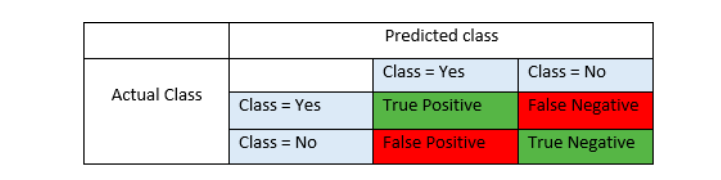

In [57]:
Image("confusion.png",width=500,height=600)

In [59]:
print("Extreme Gradient Boosting")
print("F1 score")
print(metrics.f1_score(y_test,prediction_xgb))
print("Confusion metrix")
print(metrics.confusion_matrix(y_test,prediction_xgb))

Extreme Gradient Boosting
F1 score
0.8529411764705881
Confusion metrix
[[85287     8]
 [   32   116]]


In [54]:
print('Extreme Gradient Boosting Classifier:')
print(classification_report(y_test,prediction_xgb))

Extreme Gradient Boosting Classifier:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.94      0.78      0.85       148

    accuracy                           1.00     85443
   macro avg       0.97      0.89      0.93     85443
weighted avg       1.00      1.00      1.00     85443



In [55]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[85287     8]
 [   32   116]]


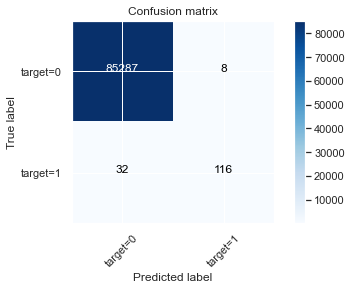

In [56]:
cnf_matrix = confusion_matrix(y_test, prediction_xgb, labels=[0,1])
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['target=0','target=1'],normalize= False,  title='Confusion matrix')

In [ ]:
There are total 85443 points in our test dataset, 
out of which 85295 points belongs to class label '0' and 148 points belong to class label '1'. 

Now from confusion matrix we can see that the value of "True Negative" is 85287 which means that out of 85295 points which belong to class '0', 85287 points are predicted as '0'. 
Furthermore, from the same confusion matrix we can see that the value of "True Positive" is 116 which means that out of 148 points which belong to class '1', 116 points are detected as '1'. 
10 point from class '0' and 2 points from class '1' are detected falsely

In conclusion, despite being an imbalanced dataset, our model is performing well. 
Even thought, there are only 148 points out of 85443 belongs to class '1', still our model is able to detect 116 of them correctly.


In [133]:
predictors=['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11','V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21','V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'normalize_amount','scaled_time']

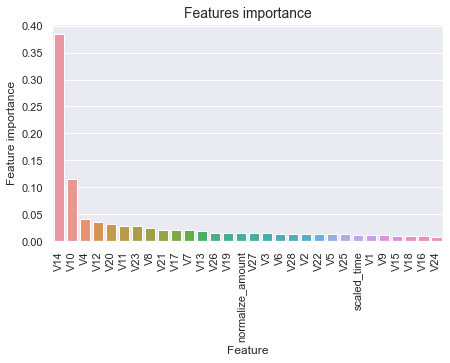

In [134]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': xgb_classifier.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()  

<b>DOWNSAMPLE</b>

Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

In [85]:
rus = RandomUnderSampler()
X_resampled, y_resampled = rus.fit_sample(X_train, y_train)

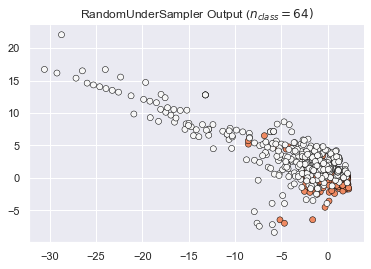

In [108]:
colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in y_resampled]
plt.scatter(X_resampled.iloc[:, 0], X_resampled.iloc[:, 1], c=colors, linewidth=0.5, edgecolor='black')
sns.despine()
plt.title("RandomUnderSampler Output ($n_{class}=64)$")
pass

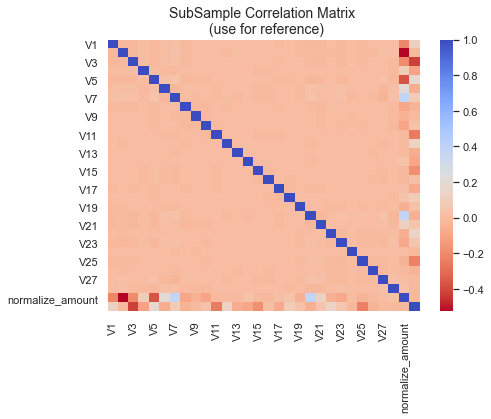

In [95]:
# Make sure we use the subsample in our correlation

f,(ax2) = plt.subplots(1,figsize=(7,5))

sub_sample_corr = X_train.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

In [109]:
xgb_classifier.fit(X_resampled, y_resampled)
prediction_xgb=xgb_classifier.predict(X_test)

[01:14:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { bootstrap, class_weight, max_features, min_samples_leaf, min_samples_split, olsample_bynode } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [110]:
print("Extreme Gradient Boosting")
print("F1 score")
print(metrics.f1_score(y_test,prediction_xgb))
print("Confusion metrix")
print(metrics.confusion_matrix(y_test,prediction_xgb))

Extreme Gradient Boosting
F1 score
0.13402061855670103
Confusion metrix
[[83633  1662]
 [   18   130]]


In [111]:
print('Extreme Gradient Boosting Classifier:')
print(classification_report(y_test,prediction_xgb))

Extreme Gradient Boosting Classifier:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85295
           1       0.07      0.88      0.13       148

    accuracy                           0.98     85443
   macro avg       0.54      0.93      0.56     85443
weighted avg       1.00      0.98      0.99     85443

